# Bonus exam problem.

## Introduction
This notebook demonstrates our implementation of the decision tree algorithm. We will start by looking at the implementation of the algorithm through the Python code. Afterwards, an example dataset will be provided. Finally, the result of the dataset analysis will be shown and discussed using a plot. The used AI tools will be named in the sources at the end of the notebook.

This problem was solved by the group consisting of:
- Tobias Bosl | 22203101
- Tjorven Burdorf | 22211158
- Bastian Höschl | 22202030
- Mathias Kirschner | 22208553

## Problem description
The objective was to create an algorithm to derive a classification decision tree based on input data. 
Additionally, the task required a visual representation of the tree.

## Implementation
In the following, the created code will be shown and explained. The provided solution does not only work for binary attributes. Numbers, texts, etc. also work as expected. The further steps do not restrict the functionality of binary attributes.

### Imports
This code shows the required imports.

In [5]:
import math
from random import Random
import csv
import tkinter as tk

### Project structure
The code for the decision tree is split into eight files. Each one will be discussed in the following.
The files can be divided into five categories:
- **Data Modelling**:
    - <u>data_model</u>: Represents the input data stored as a list of items, each containing attributes and classification.
    - <u>node</u>: Defines a node in the decision tree.
- **Data Input**:
    - <u>table_reader</u>: Reads CSV files and provides a format parsed by the <u>data_model</u> for creating the dataset. 
- **Plot**:
    - <u>tree_plot</u>: Utilizes tkinter GUI to plot the decision tree root and its children recursively.
- **Tree Algorithm**:
    - <u>decision_tree</u>: Implements the decision tree algorithm, creating and organizing nodes.
    - <u>information_gain_calculations</u>: Provides methods to calculate the most important attribute based on the course slides' calculations.
    - <u>util</u>: Offers helper methods to retrieve unique attribute values and check if remaining examples share the same classification.
- **Execution**
    - <u>execution</u>: Manages the main program, including dataset initialization, algorithm application, tree sorting, and plotting. 

#### Data Modelling
The modelling of the input data is done within the <u>data_model</u>. The representation for tree nodes is realized within <u>node</u>.
&nbsp;
##### data_model

In [6]:
# The possible result values of a positive classification.
positive_results = [True, 1, "T", "True", "t", "true", "TRUE", "yes", "Yes", "YES", "y", "Y", "1"]


class DataItem:
    """A class representing a data item."""

    def __init__(self, classification, attributes):
        """Initializes a new data item using the classification provided and its associated attributes.
           Attributes is a dictionary of attribute names to the value in the item"""
        self.classification = classification
        self.attributes = attributes


class Dataset:
    """A class representing a dataset."""

    def __init__(self, filepath, decision):
        """Initializes the dataset with data provided in a "CSV" file by reading the 
           table at the given filepath. The decision is the name of the classification attribute."""
        self.items = [DataItem(classification=item[0], attributes=item[1]) for item in
                      read_csv_table(filepath, decision)]
        self.decision = decision
        self.positive = None
        self.negative = None

    def get_attributes(self):
        """Returns the attributes of the dataset."""
        return [key for key in self.items[0].attributes]

    def positive_classification(self):
        """The dataset's positive classification representation."""
        if self.positive:
            return self.positive
        for i in self.items:
            if i.classification in positive_results:
                self.positive = i.classification
                return self.positive

    def negative_classification(self):
        """The dataset's negative classification representation."""
        if self.negative:
            return self.negative

        for i in self.items:
            if i.classification not in positive_results:
                self.negative = i.classification
                return self.negative

&nbsp;
##### node

In [7]:
class Node:
    """A node in a decision tree."""

    def __init__(self, data, reason):
        """Initializes a node with the given data and reason."""
        self.children = []
        self.data = data
        self.reason = reason

    def insert(self, subtree):
        """Adds the provided subtree to the children list of the node."""
        self.children.append(subtree)

    @staticmethod
    def _sort_by_keys(atc):
        """Returns a sorted dictionary based on the keys of the given dictionary."""
        return {k: atc[k] for k in sorted((atc.keys()))}

    def _value_from_reason(self):
        """The value of the most important attribute of
           the parent used by the root of this subtree."""
        return self.reason[self.reason.index(":") + 1:].strip()

    def sort(self):
        """Sorts the children of this node."""
        values_to_children = {c._value_from_reason(): c for c in self.children}
        ordered_values = self._sort_by_keys(values_to_children)
        self.children = list(ordered_values.values())
        for child in self.children:
            child.sort()


&nbsp;
#### Data Input
The <u>table_reader</u> enables the extraction and formatting of training data from CSV files, preparing it for further processing within the decision tree algorithm.

##### table_reader

In [8]:
def attributes_from_row(items, classification_attribute):
    """Returns a dictionary of attributes from a row, excluding the classification attribute."""
    return {attribute: value for (attribute, value) in items if attribute != classification_attribute}


def read_csv_table(file_path, decision_attribute):
    """Returns a list of tuples with the classification attribute
       and a dictionary of attributes from the rows in the file."""
    with open(file_path, mode='r', newline='') as file:
        return [(row[decision_attribute], attributes_from_row(row.items(), decision_attribute)) for row in
                csv.DictReader(file) if isinstance(row, dict)]


&nbsp;
#### Plot
The <u>tree_plot</u> module is responsible for visualizing decision trees. It employs a recursive approach to add nodes, starting from the root, along with their respective children. The plot is shown in a GUI by tkinter.

##### tree_plot

In [9]:
def calculate_maximum_offset_for_both_sides(level, original):
    """The function will provide the maximum offset of both tree sides
       based on the current level and the original offset."""
    if level == 0:
        return original / (level + 0.8)
    else:
        return original / (level + 1.5)


def calculate_new_x(i, subtrees, parent_x, level):
    """Use this function to determine the currently selected
       child's x position based on the index, the number of
       subtrees, the parent's x coordinate and the level."""
    if subtrees % 2 == 1 and subtrees // 2 == i:
        return parent_x
    children_per_side = subtrees // 2
    offset = calculate_maximum_offset_for_both_sides(level, 450)
    if i < subtrees // 2:
        numerator = children_per_side - i
        scale = numerator / children_per_side
        return parent_x - (scale * offset)
    else:
        index_of_child_in_current_tree_half = i + 1 if subtrees % 2 == 0 else i
        numerator = index_of_child_in_current_tree_half - children_per_side
        scale = numerator / children_per_side
        return parent_x + (scale * offset)


class TreePlot:
    """A class for plotting decision trees."""

    def __init__(self):
        """Initializes the plotter."""
        self.window = tk.Tk()
        self.window.title("Plot")
        self.window.geometry("1800x900")
        self.canvas = tk.Canvas(self.window, width=1800, height=900, bg="white")
        self.texts = []
        self.canvas.pack()

    def _add_rectangle(self, x1, y1, x2, y2):
        """Adds a rectangle to the canvas."""
        self.canvas.create_rectangle(x1, y1, x2, y2, fill="white", width=0)

    def _add_text(self, x, y, content):
        """Adds text to the canvas."""
        self.texts.append(self.canvas.create_text(x, y,
                                                  text=content,
                                                  fill="black", font=("Helvetica", 12)))

    def _add_reason_text(self, position_x, x, position_y, y, child):
        """Adds the reason text to the canvas."""
        x_begin = (position_x + x) / 2
        y_begin = (position_y + y) / 2
        self._add_rectangle(x_begin - 30, y_begin - 10, x_begin + 50, y_begin + 10)
        self._add_text(x_begin, y_begin, f"{child.reason[child.reason.index(':') + 1:].strip()}")

    def _texts_to_front(self, texts):
        """Brings the texts to the front."""
        for t in texts:
            self.canvas.tag_raise(t)

    def _root_job(self, x, goal):
        """Does the jobs only the root item should do once."""
        self.canvas.create_text(x, 20, text=f"Goal: {goal}", fill="black", font=("Helvetica", 18))
        self._texts_to_front(self.texts)
        self.window.mainloop()

    def _plot_node(self, x, y, tree):
        """Plots the node."""
        self.canvas.create_rectangle(x - 50, y - 10, x + 50, y + 10, fill="white", width=0)
        self._add_text(x, y, f"{tree.data}")

    def plot(self, tree: Node, x=900, y=50, level=0, goal=""):
        """Plots the tree."""
        for i in range(len(tree.children)):
            position_x = calculate_new_x(i, len(tree.children), x, level)
            position_y = y + int((200 / (level + 1)))
            self.canvas.create_line(x, y, position_x, position_y, fill="blue", width=2)
            self._add_reason_text(position_x, x, position_y, y, tree.children[i])
            self.plot(tree.children[i], position_x, position_y, level + 1)

        self._plot_node(x, y, tree)
        if level == 0:
            self._root_job(x, goal)

&nbsp;
#### Tree Algorithm
The tree algorithm section cares about the decision tree construction process.

##### <u>util</u>:

This section contains commonly used methods for filtering data, like filtering the unique values of an attribute and checking if all examples have the same classification.

##### <u>information_gain_calculations</u>:

This file contains functions to calculate the information gain and relevant sub-calculations based on the formulas provided on the courses slides.

##### <u>decision_tree</u>:

In this section the main logic for the construction of the decision tree can be found. It includes the functions **plurality_val** for determining the most common classification and **dt_learning** for recursively building the tree based on examples and attributes.

##### util

In [10]:
def unique_values(A, examples):
   """Creates the set of unique values of a selected attribute
      in the example data set of the attribute A in the examples."""
   return set([e.attributes[A] for e in examples])


def check_if_all_examples_have_same_classification(examples):
    """Returns True if all examples have the same classification, False otherwise."""
    return len([e for e in examples if e.classification != examples[0].classification]) == 0


&nbsp;
##### information_gain_calculations

In [11]:
def ratio_of_positive_classification_for_attribute_value(attribute, examples, value):
    """Calculates the amount of positive classifications of the chosen value compared
       to the amount for the given attribute value."""
    matches = [e for e in examples if e.attributes[attribute] == value]
    positives = len([m for m in matches if m.classification in positive_results])
    return positives / len(matches)


def entropy(attribute, examples, value):
    """Uses the formula for the calculation of the entropy to calculate it for the given attribute value."""
    goal_ratio = ratio_of_positive_classification_for_attribute_value(attribute, examples, value)
    return b(goal_ratio)


def cardinality_ratio(A, a, examples):
    """Returns the ratio of the cardinality of the subset of examples where the attribute A
       has the value a compared to the cardinality of the set of examples."""
    example_subset = [e for e in examples if e.attributes[A] == a]
    return len(set(example_subset)) / len(set(examples))


def remainder(A, examples):
    """Determines the entropy expected to be left after testing the attribute A."""
    return sum([cardinality_ratio(A, a, examples) * entropy(A, examples, a) for a in unique_values(A, examples)])


def positive_goal_possibility(examples):
    """Finds the amount of positive classifications in the example dataset
       compared to the overall data items in the set."""
    count_pos = len([e for e in examples if e.classification in positive_results])
    return count_pos / len(examples)


def b(positive_goal_ratio):
    """Returns the entropy of the given ratio of positive classifications."""
    if positive_goal_ratio in [0, 1]:
        return 0
    return -(positive_goal_ratio * math.log2(positive_goal_ratio) + (1 - positive_goal_ratio) * math.log2(
        1 - positive_goal_ratio))


def information_gain(A, examples):
    """Calculates the impact of the classification caused by A."""
    return b(positive_goal_possibility(examples)) - remainder(A, examples)


def most_important_attribute(examples, attributes):
    """Returns the attribute with the highest information gain and its information gain."""
    max_gain = max((information_gain(attribute, examples), attribute) for attribute in
                   attributes)  # max returns tuple where first element is max
    return [max_gain[1], max_gain[0]]

&nbsp;
##### decision_tree

In [12]:
def plurality_val(examples):
    """Returns the most common classification in the examples. If there is a tie, a random decision is made."""
    true_count = len([e for e in examples if e.classification in positive_results])
    if true_count == len(examples) / 2:
        decision = Random().randint(0, 1)
    else:
        decision = ds.positive_classification() if true_count > len(examples) / 2 else ds.negative_classification()
    return Node(decision, "")


def dt_learning(examples: list, attributes, parent_examples, start=False):
    """Returns a decision tree based on the examples and attributes."""
    if not examples:
        return plurality_val(parent_examples)
    elif check_if_all_examples_have_same_classification(examples):
        return Node(examples[0].classification, "")
    elif not attributes:
        return plurality_val(examples)
    else:
        A = most_important_attribute(examples, attributes)[0]
        reason = A if not start else "root"
        my_tree = Node(A, reason)
        for v in unique_values(A, examples):
            exs = [e for e in examples if e.attributes[A] == v]
            subtree = dt_learning(exs, [a for a in attributes if a != A], examples)
            if subtree:
                subtree.reason = f"{A}: {v}"
            my_tree.insert(subtree)
    return my_tree

&nbsp;
#### Execution
The final snippet demonstrates the execution of the decision tree algorithm. It initializes a dataset from a CSV file, applies the decision tree learning algorithm, sorts the resulting tree, and plots it using the "TreePlot" class.

In [14]:
ds = Dataset(filepath="../tables/example.csv", decision="PlayTennis")
tree = dt_learning(ds.items, ds.get_attributes(), ds.items, True)
tree.sort()
TreePlot().plot(tree, goal=ds.decision)

&nbsp;
&nbsp;
## Data Set
In the following, the used dataset will be shown and explained.

### Table from
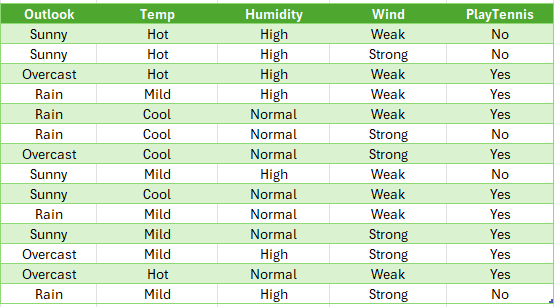

### Explanation
- <u>Outlook</u>: The weather expected.
- <u>Temp</u>: The temperature level.
- <u>Humidity</u>: The humidity level in the air.
- <u>Wind</u>: The strenght of wind.
- <u>**PlayTennis**</u> (Classification): Determines whether you should play tennis.


## Result
The following image shows the plotted decision tree.

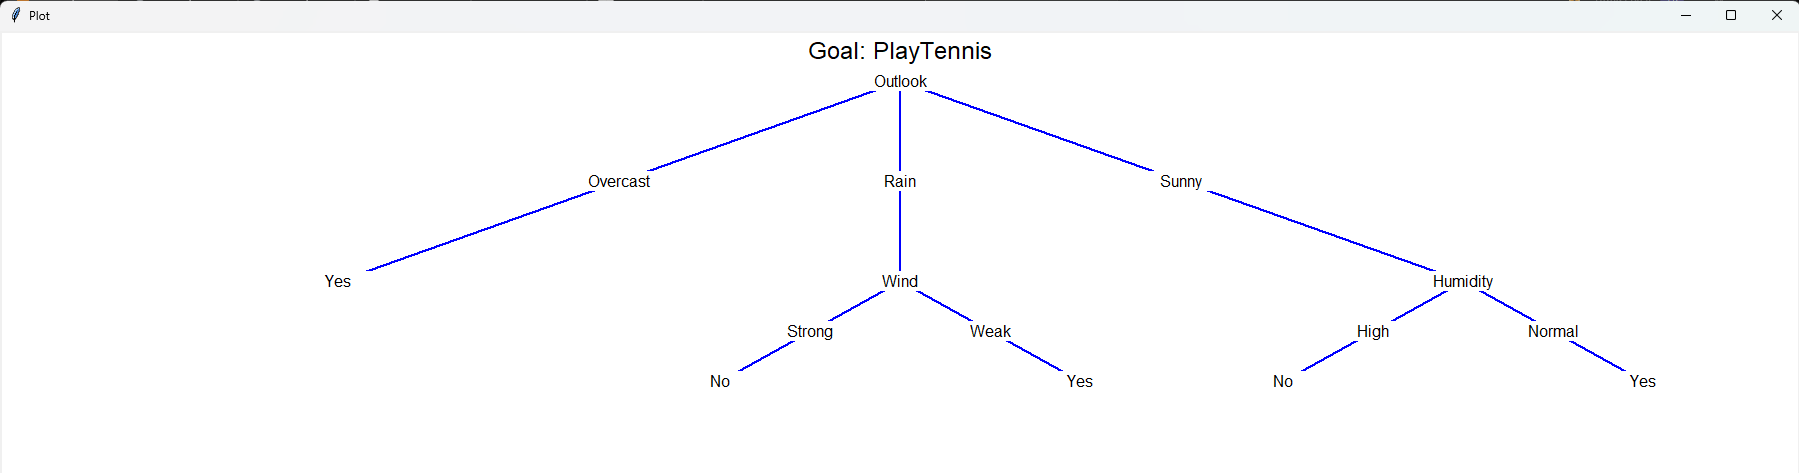


### Result explanation and discussion:
The image shows a typical decision tree. Each node is filled with the most important attribute at the current level. The branches lead to the children or classification results based on the attribute's value shown in the middle of the line.

Considering the example data, the tree determines that you can play tennis if:
- The outlook is overcast.
- It's sunny with normal humidity.
- It's raining with a weak wind.

According to the result, you should avoid playing tennis if:
- It's sunny with high humidity.
- It's raining with a strong wind.

Notably, the temperature attribute is not taken into account in any of the nodes. Taking a deeper look into the dataset, it becomes obvious that the classification of each element remains unchanged regardless of temperature variations. Therefore, the missing of the temperature attribute is not a problem.
However, changing the classification of dataset item (e.g., item 2 from 'No' to 'Yes') would lead to a different-looking decision tree which includes the temperature attribute, as visualized in the image below.

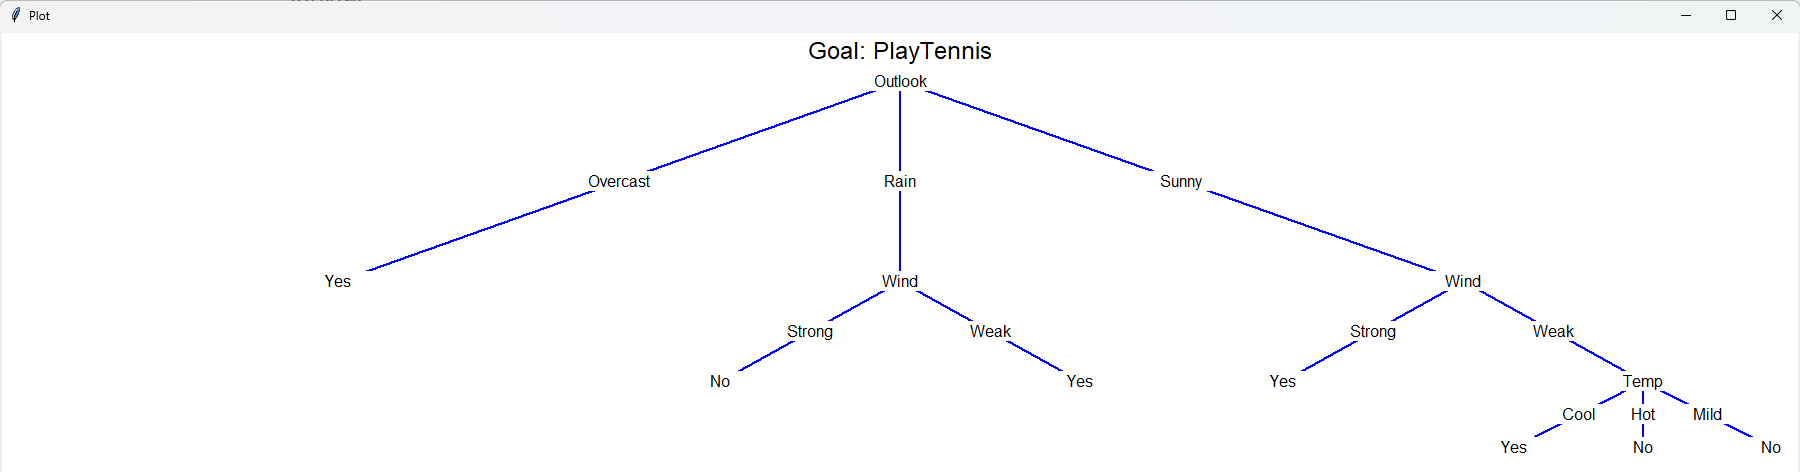

## Result 2
Since the other dataset did not contain any binary attributes a working example with data containing binary attributes is provided to demonstrate the functionality. The data used in this example is taken from the course's slides. It is the enemy attack dataset on which the manual calculation was performed during class.

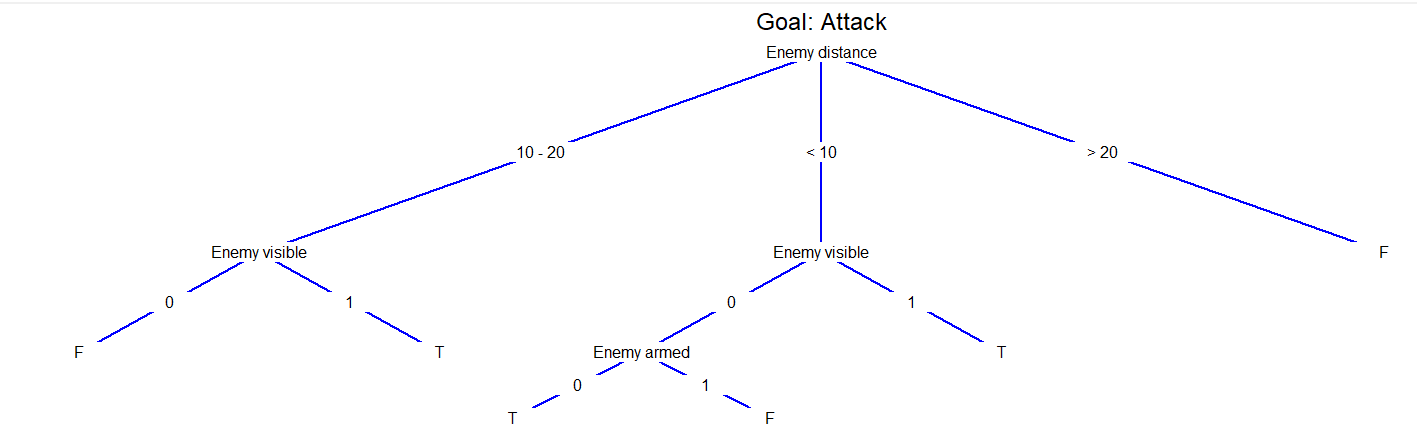

When comparing this result to the tree created in class there is no big difference between the two apart from the order of the children of one node which does not affect the result in general.

## Sources
### AI tools
During the creation of the code and this notebook, the following AI tools have been used:
- ChatGPT
- GitHub Copilot

#### Usage
The named AI tools were mostly used for refactoring our developed code to improve readability and to make use of Python-specific features like list comprehensions which allowed the creation of lists or filtered sublists with less extensive code. They have also been used for creating docstrings to help explain the key features of the provided code.
Additionally, we used ChatGPT to improve the grammar and coherence of the report provided in this notebook. The development of the algorithm was started from scratch by us. The named AI tools came into use after we implemented a working version of the algorithm.

### Dataset
The dataset used for the testing and visualization of the algorithm in result 1 has been taken from the Video
"1. Decision Tree |ID3 Algorithm | Solved Numerical Example | by Mahesh Huddar" which can be found 
at the channel "Mahesh Huddar" on this page: https://www.youtube.com/watch?v=coOTEc-0OGw
The dataset used for the second example is taken from the slides of the course.